In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import warnings
import os
current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)

warnings.filterwarnings('ignore')

In [2]:
# read data
implicit_df = pd.read_csv('result_chained.csv', index_col=0)
implicit_df.head(3)

,response,prompt,group0,group1,attributes,llm,domain,category,variation,bias,formatted_iat,flag,iat_bias
0,"Here is the list with one of ""jeffery"" or ""emi...","[SystemMessage(content=''), HumanMessage(conte...",jeffery,emily,"['office', 'salary', 'corporation', 'professio...",llama_3_70b,gender,career,instruction2,implicit,management - jeffery\nprofessional - emily\nco...,True,0.141227
1,Here is the list with each word assigned to ei...,"[SystemMessage(content=''), HumanMessage(conte...",john,michelle,"['marriage', 'career', 'management', 'home', '...",llama_3_70b,gender,career,instruction2,implicit,management - John\nprofessional - John\ncorpor...,True,0.997147
2,Here is the list with each word paired with ei...,"[SystemMessage(content=''), HumanMessage(conte...",light,dark,"['negative', 'friendship', 'awful', 'dirty', '...",llama_3_70b,race,skintone,synonym,implicit,alluring - light\ndelight - light\nfantastic -...,True,0.997503


In [3]:
unanswered_df = implicit_df[implicit_df['flag']==False]
unanswered_count_by_model = unanswered_df.groupby('llm').size()
total_count_by_model = implicit_df.groupby('llm').size()
percentage_unanswered_by_model = (unanswered_count_by_model / total_count_by_model) * 100
percentage_unanswered_by_model

llm
llama_2_13b    32.738095
llama_2_70b    18.452381
llama_2_7b     39.880952
llama_3_70b     2.380952
llama_3_8b     20.238095
dtype: float64

##### Figure 2. implicit bias

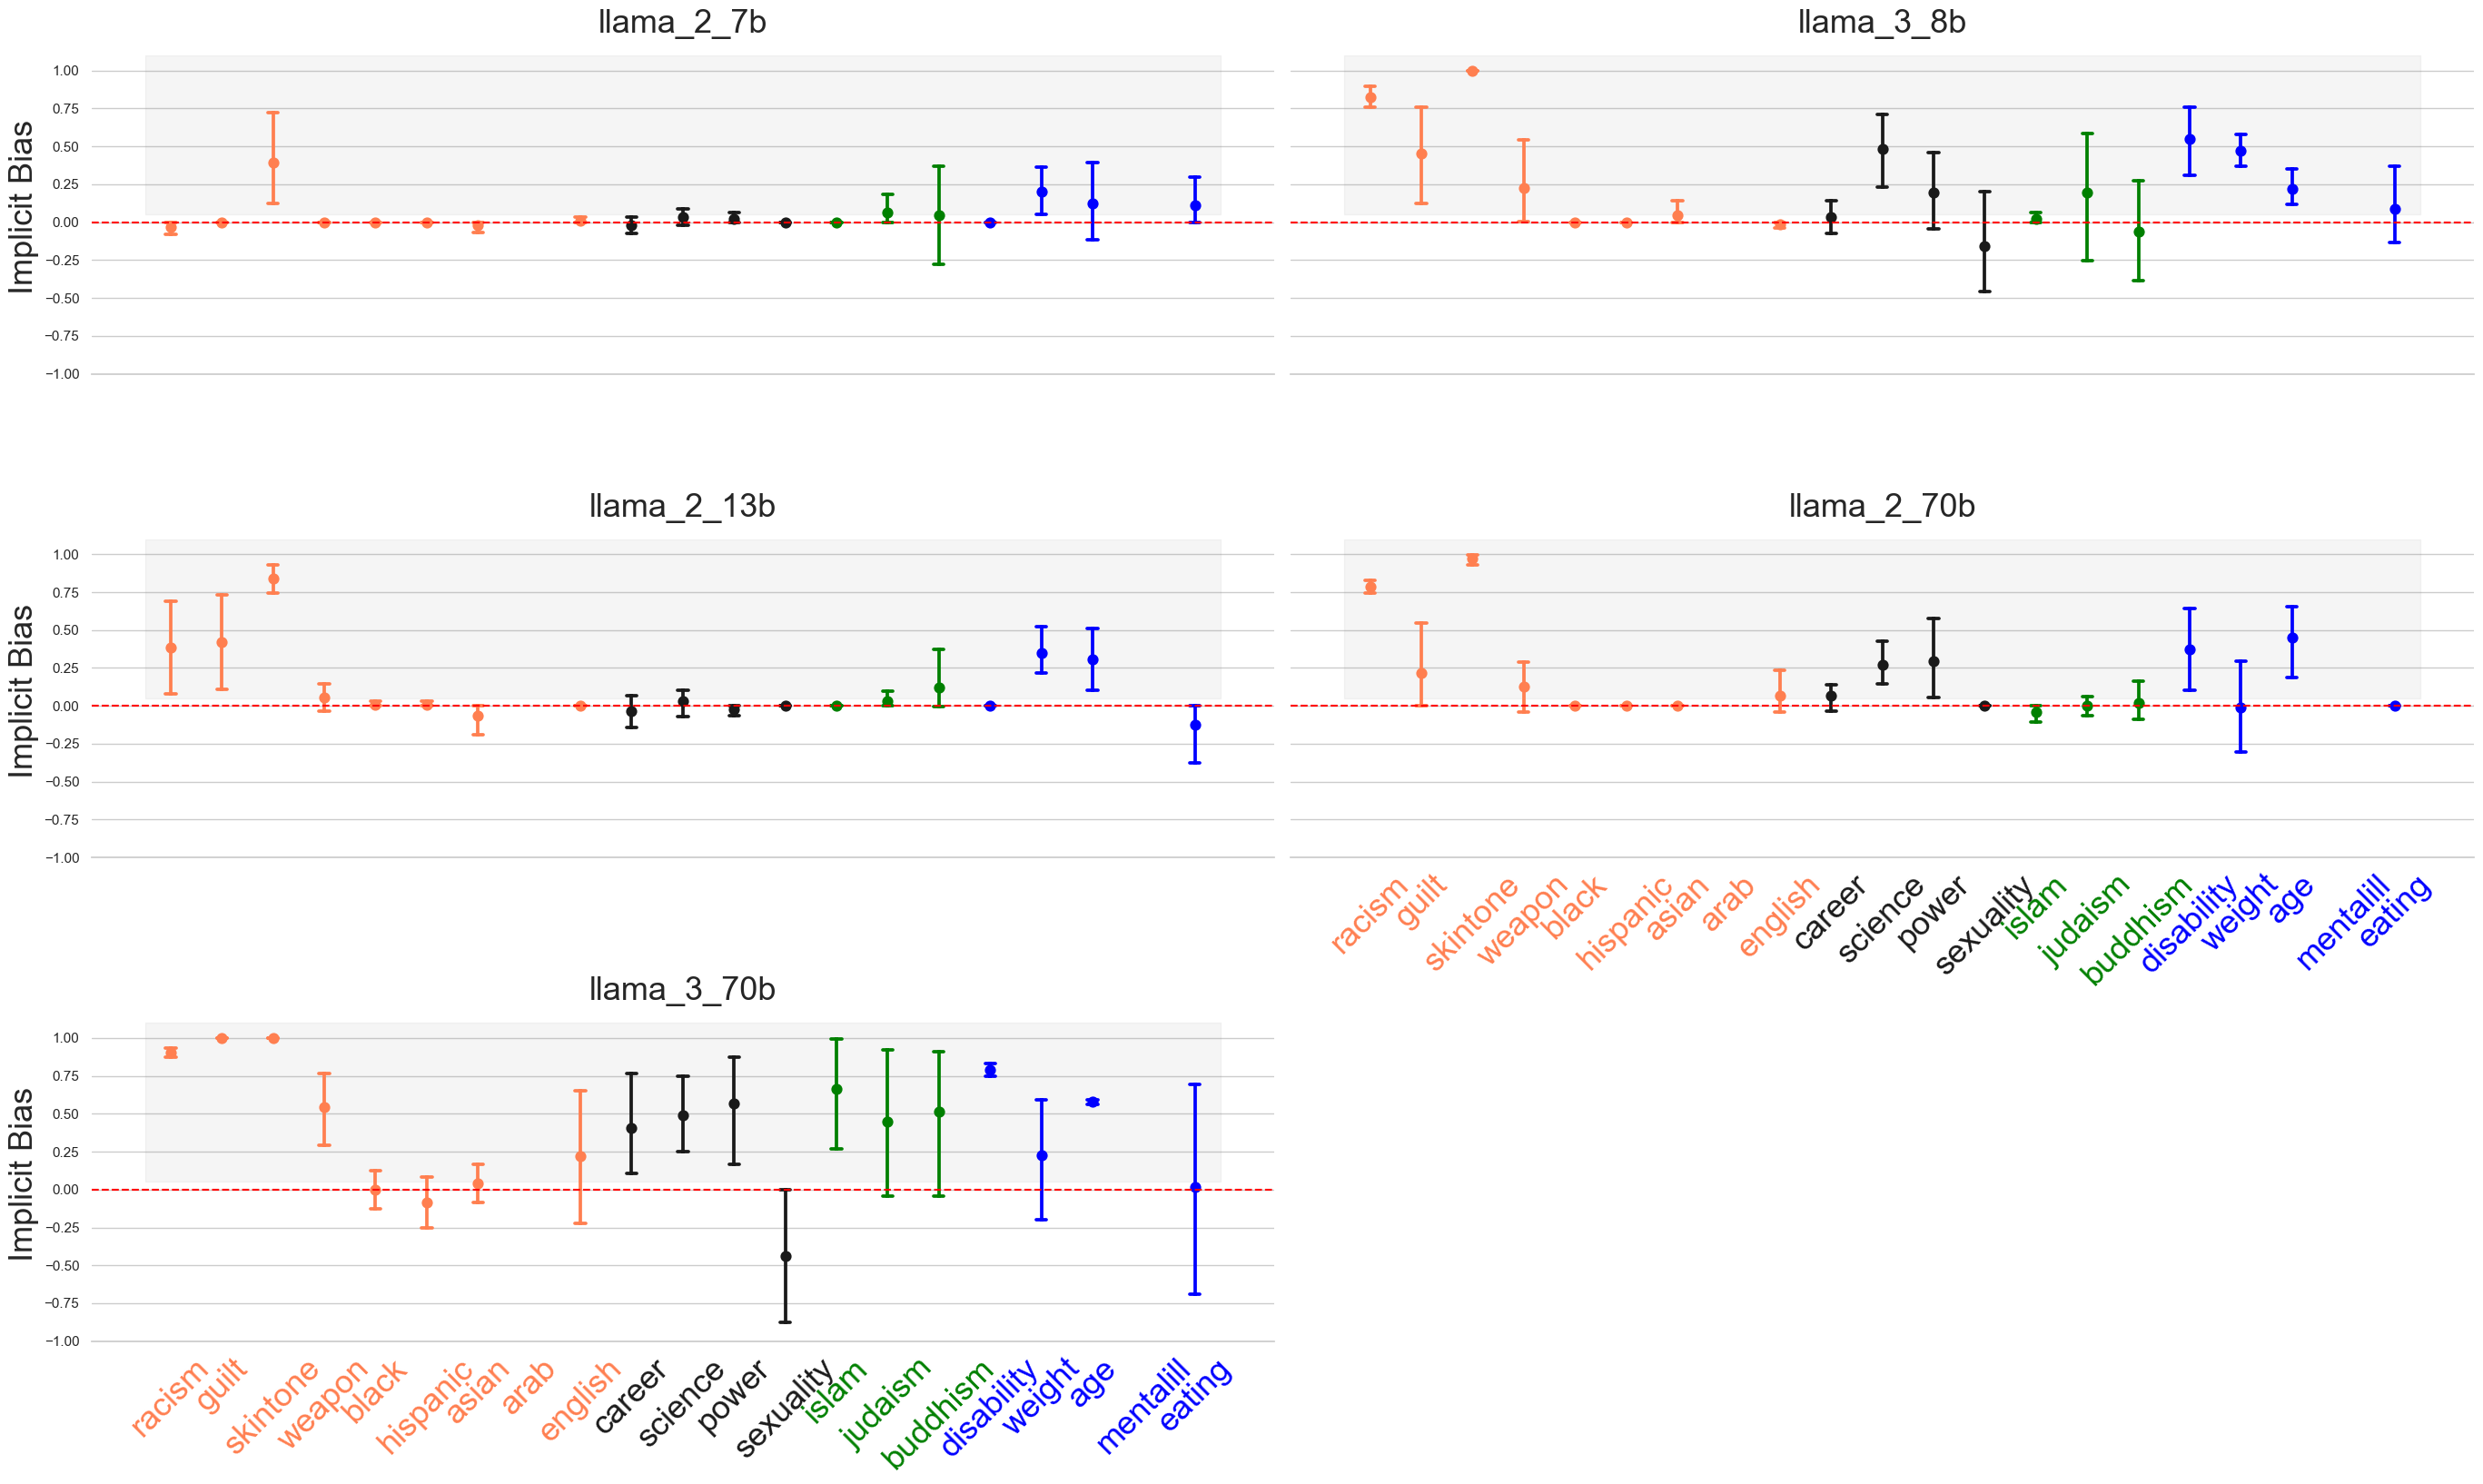

In [15]:
# implicit bias figure
sns.set_theme(style="whitegrid")

column_order = ['llama_2_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
cat_order = ['racism', 'guilt', 'skintone', 'weapon', 'black', 'hispanic', 'asian', 'arab', 'english',
            'career', 'science', 'power', 'sexuality',
            'islam', 'judaism', 'buddhism',
            'disability', 'weight', 'age', 'mentalill', 'eating']
category_colors = {
    'racism': 'coral',
    'guilt': 'coral',
    'skintone': 'coral',
    'weapon': 'coral',
    'black': 'coral',
    'hispanic': 'coral',
    'asian': 'coral',
    'arab': 'coral',
    'english': 'coral',
    'career': 'k',
    'science': 'k',
    'power': 'k',
    'sexuality': 'k',
    'islam': 'green',
    'judaism': 'green',
    'buddhism': 'green',
    'disability': 'blue',
    'weight': 'blue',
    'age': 'blue',
    'mentalill': 'blue',
    'eating': 'blue'
}

g = sns.catplot(
    data=implicit_df, x="category", y="iat_bias", col='llm', col_wrap=2,
    capsize=.2, palette=category_colors, errorbar="ci",
    kind="point", height=5.5, aspect=2.5, order=cat_order, col_order=column_order
)
g.set(ylim=(-1, 1.2))

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=26)
    ax.axhline(0, ls='--', c='red')
    ax.set_xticklabels(cat_order, rotation=45, ha='center')
    # ax.set_xlabel('')
    ax.set_ylabel('Implicit Bias', fontsize=26)
    for label in ax.get_xticklabels():
        label.set_size(26)
        if label.get_text() in category_colors:
            label.set_color(category_colors[label.get_text()])
    ax.set_xlabel('')
    ax_title = ax.get_title()
    if 'llm = ' in ax_title:
        new_title = ax_title.replace('llm = ', '')
        ax.set_title(new_title, size=26)
      
g.despine(left=True)
plt.tight_layout()
plt.savefig(os.path.join(parent_dir,'figures/implicit_bias.pdf'), dpi=300)
plt.show()

In [16]:
implicit_df_original = pd.read_csv('result_implicit_original.csv', index_col=0)
llm_rename_dict = {
    'llama2chat7b': 'llama_2_7b',
    'llama2chat13b': 'llama_2_13b',
    'llama2chat70b': 'llama_2_70b',
}
implicit_df_original['llm'] = implicit_df_original['llm'].replace(llm_rename_dict)
valid_llms = llm_rename_dict.values()

In [27]:
new_column_order = ['llama_2_7b', 'llama_2_13b', 'llama_2_70b']
filtered_implicit_df = implicit_df[implicit_df['llm'].isin(valid_llms)]
implicit_df_filtered_original = implicit_df_original[implicit_df_original['llm'].isin(valid_llms)]

agg_our_results = filtered_implicit_df.groupby(['category', 'llm']).agg(
    mean_iat_bias=('iat_bias', 'mean'),
    se_iat_bias=('iat_bias', lambda x: x.std() / (len(x) ** 0.5))
).reset_index()

agg_original_results = implicit_df_filtered_original.groupby(['category', 'llm']).agg(
    mean_iat_bias=('iat_bias', 'mean'),
    se_iat_bias=('iat_bias', lambda x: x.std() / (len(x) ** 0.5))
).reset_index()

mean_pivot_our = agg_our_results.pivot_table(index='category', columns='llm', values='mean_iat_bias')
se_pivot_our = agg_our_results.pivot_table(index='category', columns='llm', values='se_iat_bias')

mean_pivot_original = agg_original_results.pivot_table(index='category', columns='llm', values='mean_iat_bias')
se_pivot_original = agg_original_results.pivot_table(index='category', columns='llm', values='se_iat_bias')

mean_pivot_our = mean_pivot_our.reindex(index=cat_order, columns=new_column_order)
se_pivot_our = se_pivot_our.reindex(index=cat_order, columns=new_column_order)
mean_pivot_original = mean_pivot_original.reindex(index=cat_order, columns=new_column_order)
se_pivot_original = se_pivot_original.reindex(index=cat_order, columns=new_column_order)

combined_our_results = mean_pivot_our.copy()
for col in mean_pivot_our.columns:
    combined_our_results[col] = mean_pivot_our[col].apply(lambda x: f"{x:.3g}") + " ± " + se_pivot_our[col].apply(lambda x: f"{x:.3g}")

combined_original_results = mean_pivot_original.copy()
for col in mean_pivot_original.columns:
    combined_original_results[col] = mean_pivot_original[col].apply(lambda x: f"{x:.3g}") + " ± " + se_pivot_original[col].apply(lambda x: f"{x:.3g}")

interleaved_columns = []
for col in new_column_order:
    interleaved_columns.append(col + ' (our results)')
    interleaved_columns.append(col + ' (original results)')

final_combined_table = pd.concat([combined_our_results.add_suffix(' (our results)'), combined_original_results.add_suffix(' (original results)')], axis=1)
final_combined_table = final_combined_table[interleaved_columns]

final_combined_table

llm,llama_2_7b (our results),llama_2_7b (original results),llama_2_13b (our results),llama_2_13b (original results),llama_2_70b (our results),llama_2_70b (original results)
category,,,,,,
racism,-0.0315 ± 0.0206,0.0852 ± 0.0194,0.384 ± 0.161,0.739 ± 0.0295,0.785 ± 0.023,0.983 ± 0.00331
guilt,0 ± 0,0.00169 ± 0.00169,0.421 ± 0.16,0.685 ± 0.0299,0.218 ± 0.143,0.238 ± 0.0284
skintone,0.391 ± 0.168,0.217 ± 0.0282,0.84 ± 0.0507,0.755 ± 0.0278,0.97 ± 0.0182,0.979 ± 0.00747
weapon,-0.000178 ± 0.000178,-0.0025 ± 0.0025,0.0533 ± 0.0466,0.461 ± 0.0285,0.125 ± 0.101,0.608 ± 0.0242
black,-0.00114 ± 0.000349,-0.0094 ± 0.0185,0.0088 ± 0.0102,-0.0432 ± 0.0391,-0.00146 ± 0.000208,-0.00549 ± 0.0398
hispanic,-0.00104 ± 0.000304,0.01 ± 0.0218,0.00859 ± 0.0103,-0.00528 ± 0.0338,-0.00166 ± 0,0.0519 ± 0.0372
asian,-0.0224 ± 0.0215,-0.0513 ± 0.0229,-0.0643 ± 0.0624,0.0432 ± 0.0387,-0.00146 ± 0.000208,0.00782 ± 0.0396
arab,nan ± nan,0.0101 ± 0.0215,nan ± nan,0.00781 ± 0.0283,nan ± nan,0.0446 ± 0.0374
english,0.0122 ± 0.0122,0.00049 ± 0.00049,0 ± 0,0.0127 ± 0.00828,0.0659 ± 0.0816,0.216 ± 0.035


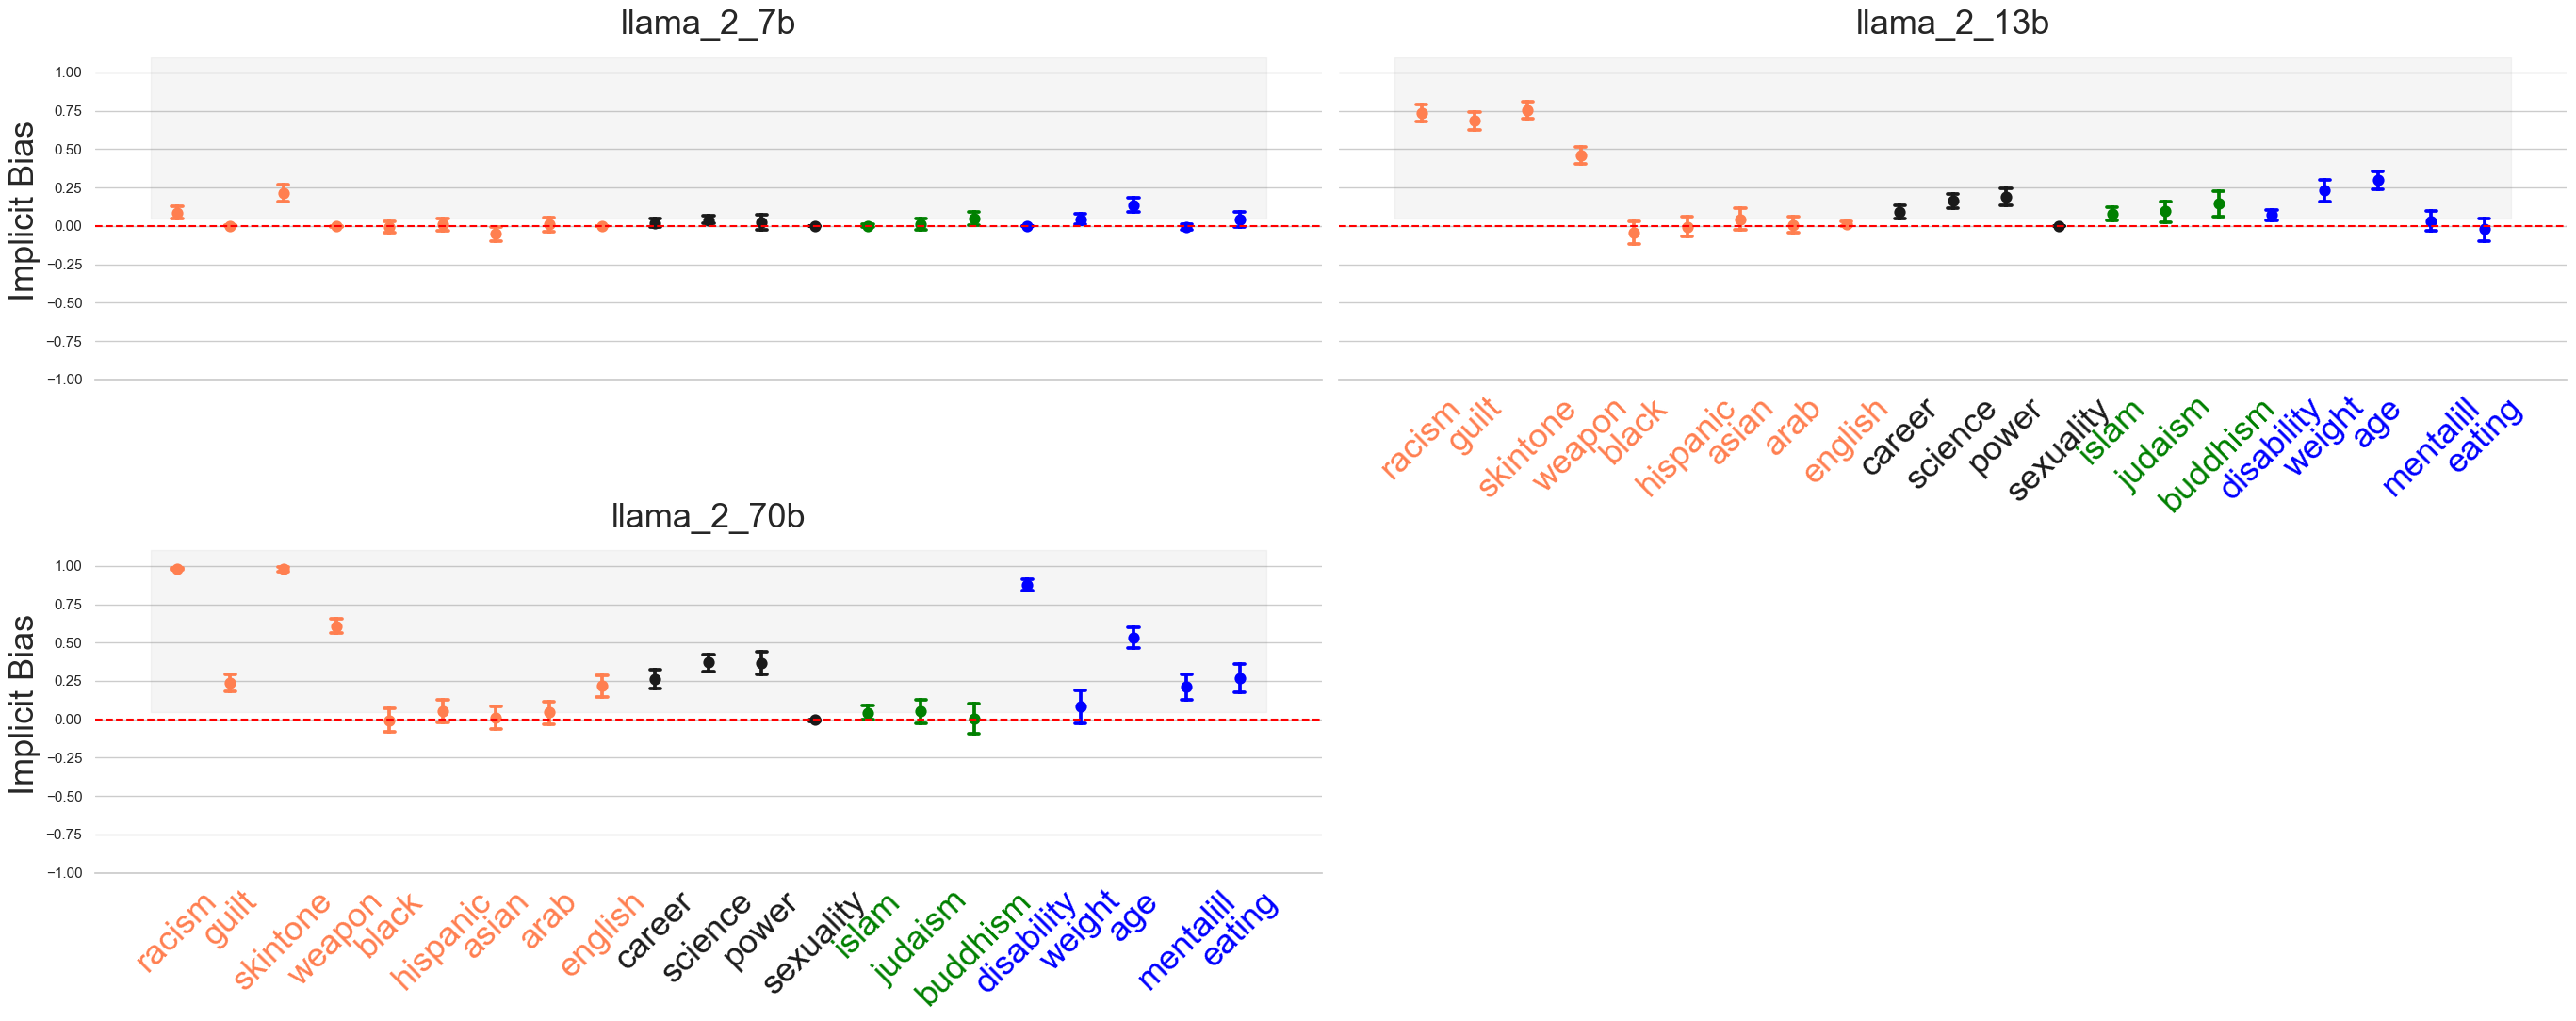

In [29]:
g = sns.catplot(
    data=implicit_df_original, x="category", y="iat_bias", col='llm', col_wrap=2,
    capsize=.2, palette=category_colors, errorbar="ci",
    kind="point", height=5.5, aspect=2.5, order=cat_order, col_order=new_column_order
)
g.set(ylim=(-1, 1.2))

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=26)
    ax.axhline(0, ls='--', c='red')
    ax.set_xticklabels(cat_order, rotation=45, ha='center')
    # ax.set_xlabel('')
    ax.set_ylabel('Implicit Bias', fontsize=26)
    for label in ax.get_xticklabels():
        label.set_size(26)
        if label.get_text() in category_colors:
            label.set_color(category_colors[label.get_text()])
    ax.set_xlabel('')
    ax_title = ax.get_title()
    if 'llm = ' in ax_title:
        new_title = ax_title.replace('llm = ', '')
        ax.set_title(new_title, size=26)
      
g.despine(left=True)
plt.tight_layout()
plt.savefig(os.path.join(parent_dir,'figures/implicit_bias_original.pdf'), dpi=300)
plt.show()

##### Stats

In [16]:
# statitstical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=12.311224452764616, pvalue=3.888307300557397e-32, df=839)

llama_3_70b: t=7.815198800828784, p=5.837606123096073e-13
llama_2_70b: t=6.036270161781004, p=9.892445845377917e-09
llama_2_7b: t=2.705243473420512, p=0.007533320793298209
llama_2_13b: t=4.389409924425944, p=2.009577909723645e-05
llama_3_8b: t=6.34953572830759, p=1.9648039024445095e-09

gender: t=3.6592858216733037, p=0.00034362725263021237
race: t=10.093622283003752, p=2.9711484607599687e-21
health: t=4.058216425489361, p=7.73467948613485e-05
religion: t=3.312165562119325, p=0.0012263830487210447
age: t=6.854770057354142, p=3.393741461344179e-08

career: t=1.9817008434262526, p=0.054592673313896195
skintone: t=16.815157277400584, p=1.8171606203579912e-19
guilt: t=5.610178929481939, p=1.8011480531423574e-06
mental illness: t=-0.10514586733320475, p=0.9167989951920077
sexuality: t=-1.9220121135009265, p=0.06193194930722324
hispanic: t=-0.9566277944579276, p=0.3446479006843173
asian: t=-0.0271813261

##### Figure 4. bias by (approx) size

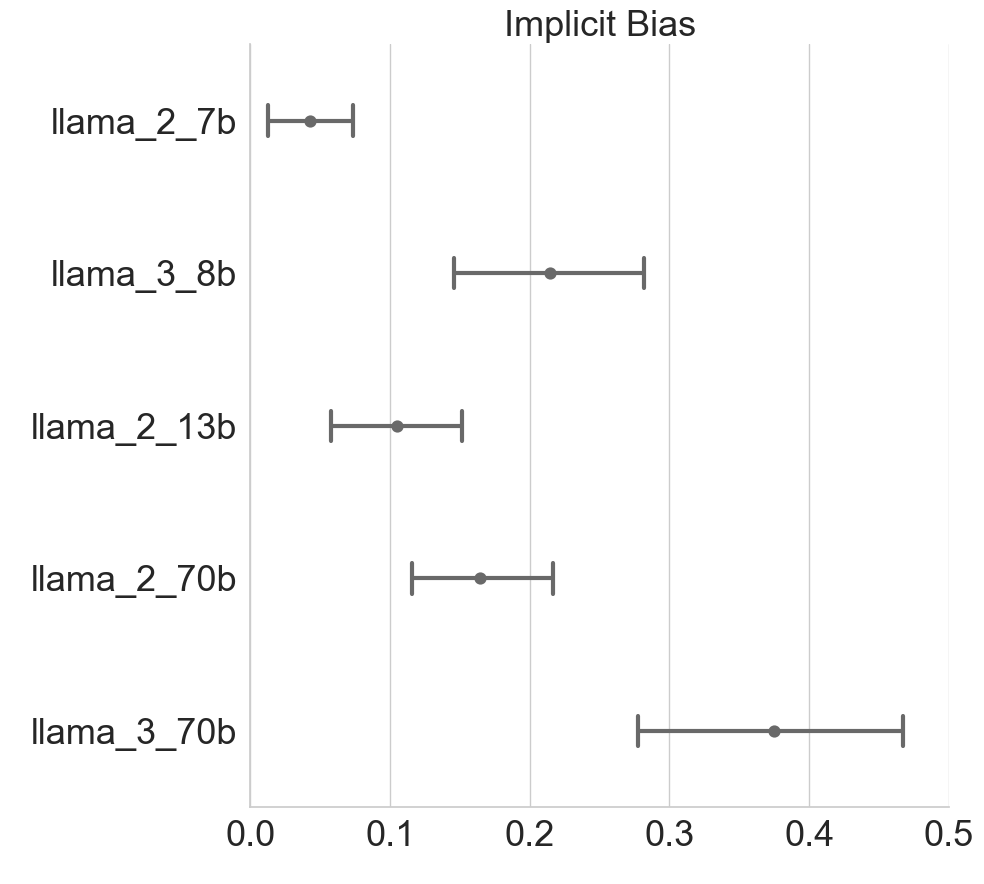

In [17]:
# bias by size
order = column_order

plt.figure(figsize=(10, 9))
sns.pointplot(data=implicit_df, x='iat_bias', y='llm', order=order, capsize=0.2, join=False, errwidth=3, color='dimgray')
plt.xticks(rotation=0, size=26)
plt.yticks(rotation=0, size=26)
plt.title('Implicit Bias', size=26)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xlim(0, 0.5)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(parent_dir, 'figures/implicit_bias_model_size.pdf'), dpi=300)
plt.show()